# Getting Started with Azure Machine Learning
This guide follows the official guided learning, more information [here](https://github.com/microsoftdocs/mslearn-aml-labs).

Lets begin by checking the version of the installed azureml.

In [1]:
import azureml.core
print(f'The version of Azure ML we have installed is: {azureml.core.VERSION}')

The version of Azure ML we have installed is: 1.6.0


# Connect to our Workspace
In AML, all experiments and resources associated with an experiment, are managed in an Azure ML workspace. You can connect to a workspace, ore create one via code using the Azure ML SDK.

Best practice is to store the workspace configuration as a JSON config file. This makes it easier to reconnect without having to remember details such as your azure subscription ID. This can also be downloaded from the AMl resource via the portal. If you are using a compute instance, it has already been downloaded to your workspace and added to your root folder.

In [2]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(f'The following workspace has been loaded: {ws.name}')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code C4HJ4DGPX to authenticate.
Interactive authentication successfully completed.
The following workspace has been loaded: timers-aml


 # Run an Experiment

Starting experiment: diabetes-experiment
Analysing 10000 rows of data.


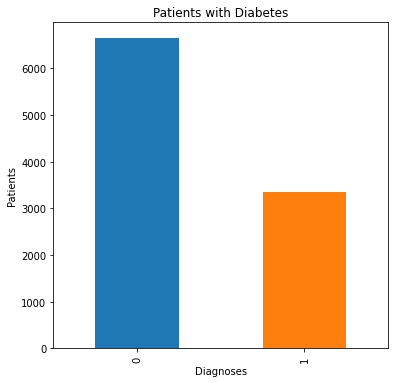

In [6]:
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt

# create ml experiment (a named process)
experiment = Experiment(workspace = ws, name='diabetes-experiment')

# start logging - running experiment in this notebook.
run = experiment.start_logging()
print(f'Starting experiment: {experiment.name}')

# load data
df = pd.read_csv('data/diabetes.csv')

# count rows
row_count = len(df)

# log variable
run.log('observation', row_count)
print(f'Analysing {row_count} rows of data.')

# plot and log count of diabetic vs non-diabetic patients
diabetic_counts = df['Diabetic'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
diabetic_counts.plot.bar(ax=ax)
ax.set_title('Patients with Diabetes')
ax.set_xlabel('Diagnoses')
ax.set_ylabel('Patients')
plt.show()

run.log_image(name='label distribution', plot= fig)

# log distinct pregnancy counts
pregnancies = df.Pregnancies.unique()
run.log_list('pregnancy categories', pregnancies)

# log summary stats for numeric columns
med_columns = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']
summary_stats = df[med_columns].describe().to_dict()
for col in summary_stats:
    keys = list(summary_stats[col].keys())
    values = list(summary_stats[col].values())
    for index in range(len(keys)):
        run.log_row(col, stat=keys[index], value=values[index])
        
# save a sample of the data and upload it to the experiment output
df. sample(100).to_csv('sample.csv', index=False, header=True)
run.upload_file(name='outputs/sample.csv', path_or_stream='./sample.csv')

# complete run
run.complete()

 # View Experiment results

In [7]:
import json 

# get run details
details = run.get_details()
print(details)

# get logged metrics
metrics = run.get_metrics()
print(json.dumps(metrics, indent=2))

# get output files
files = run.get_file_names()
print(json.dumps(files, indent=2))

{'runId': '13b9c932-f69e-455c-8349-97ea03229050', 'target': 'sdk', 'status': 'Completed', 'startTimeUtc': '2020-06-01T18:49:31.571418Z', 'endTimeUtc': '2020-06-01T18:49:38.042448Z', 'properties': {'azureml.git.repository_uri': 'https://github.com/microsoftdocs/mslearn-aml-labs', 'mlflow.source.git.repoURL': 'https://github.com/microsoftdocs/mslearn-aml-labs', 'azureml.git.branch': 'master', 'mlflow.source.git.branch': 'master', 'azureml.git.commit': '387548e2d70ab1dab5e0a1ea860e1f08dd09feae', 'mlflow.source.git.commit': '387548e2d70ab1dab5e0a1ea860e1f08dd09feae', 'azureml.git.dirty': 'True', 'ContentSnapshotId': '047ece11-d359-4b54-b55f-acb473177821'}, 'inputDatasets': [], 'logFiles': {}}
{
  "label distribution": "aml://artifactId/ExperimentRun/dcid.13b9c932-f69e-455c-8349-97ea03229050/label distribution_1591037376.png",
  "observation": 10000,
  "pregnancy categories": [
    0,
    8,
    7,
    9,
    1,
    3,
    5,
    2,
    6,
    11,
    4,
    13,
    10,
    12,
    14
  ],


Instead of returning a json, such as above, instead we can return a jupyter based widget.

In [8]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

# Run an experiment via a script

In [9]:
# lets create a folder and store our files in it
import os, shutil
folder_name = 'diabetes-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok=True)

# copy data file into experiment folder
shutil.copy('data/diabetes.csv', os.path.join(folder_name, "diabetes.csv"))

'diabetes-experiment-files/diabetes.csv'

Create a python script and save it in the same folder

In [10]:
%%writefile $folder_name/diabetes_experiment.py
from azureml.core import Run
import pandas as pd
import os

# get run context
run = Run.get_context()

data = pd.read_csv('diabetes.csv')
row_count = len(data)
run.log('observations', row_count)

# Count and log the label counts
diabetic_counts = data['Diabetic'].value_counts()
print(diabetic_counts)
for k, v in diabetic_counts.items():
    run.log('Label:' + str(k), v)
      
# Save a sample of the data in the outputs folder (which gets uploaded automatically)
os.makedirs('outputs', exist_ok=True)
data.sample(100).to_csv("outputs/sample.csv", index=False, header=True)

# Complete the run
run.complete()

Writing diabetes-experiment-files/diabetes_experiment.py


the above code generates the script, and stores it in our folder. From the code, we use:
- run.get_context(): this method retreives the experiment run context when script is run
- loads diabetes data from the folder where the script is loaded
- creates output folder and writes the samples to it

Now we need to setup our configuration files:
- create a `run configuration` that defines the python code execution environment for the script. hence with the right conda environment and python packages
- create a `script configuration` file that IDs python script file to run in an experiment, with the right environment

In [11]:
import os
import sys
from azureml.core import Experiment, RunConfiguration, ScriptRunConfig
from azureml.widgets import RunDetails

# create a new runconfig object
experiment_run_config = RunConfiguration()

# create script config
src = ScriptRunConfig(source_directory = experiment_folder,
                     script='diabetes_experiment.py',
                     run_config=experiment_run_config)

#submit experiment
experiment = Experiment(workspace=ws, name='diabetes-experiment')
run=experiment.submit(config=src)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'diabetes-experiment_1591040048_0010fb16',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2020-06-01T19:35:30.54747Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'b5ee8b02-612f-4fae-8fdf-a3b612e728a0',
  'azureml.git.repository_uri': 'https://github.com/microsoftdocs/mslearn-aml-labs',
  'mlflow.source.git.repoURL': 'https://github.com/microsoftdocs/mslearn-aml-labs',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '387548e2d70ab1dab5e0a1ea860e1f08dd09feae',
  'mlflow.source.git.commit': '387548e2d70ab1dab5e0a1ea860e1f08dd09feae',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDu

Instead of using the above widget, lets retreive it from azure using code.

In [12]:
# get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
    print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

observations 10000
Label:0 6656
Label:1 3344


azureml-logs/60_control_log.txt
azureml-logs/70_driver_log.txt
logs/azureml/40077_azureml.log
outputs/sample.csv


# View experiment run history

In [ ]:
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['diabetes-experiment']
for logged_run in diabetes_experiment.get_runs():
    print('run id:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))

run id: diabetes-experiment_1591040048_0010fb16
- observations 10000
- Label:0 6656
- Label:1 3344
run id: 13b9c932-f69e-455c-8349-97ea03229050
- label distribution aml://artifactId/ExperimentRun/dcid.13b9c932-f69e-455c-8349-97ea03229050/label distribution_1591037376.png
- observation 10000
- pregnancy categories [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
- PlasmaGlucose {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 107.8502, 31.920909360565563, 44, 84, 105, 129, 192]}
- TricepsThickness {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 28.8176, 14.506480415228332, 7, 15, 31, 41, 92]}
- SerumInsulin {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 139.2436, 133.77791937465278, 14, 39, 85, 197, 796]}
- BMI {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 31.56702174359113, 9.804365693559113, 18.20080735, 21.247426835, 3